### Multi-Head Attention

Multi-Head Attention is a mechanism that allows the model to focus on different parts of the input sequence simultaneously by using multiple "attention heads." Each head computes an independent scaled dot-product attention, capturing unique aspects of the input, and these results are then concatenated and transformed to produce the final output.

#### Key Components

Given an input sequence, each token (word, symbol, etc.) in the sequence is represented as a vector. For a sequence of $n$ tokens, let the input be represented as a matrix $X$ of shape $n \times d_{\text{model}}$, where $d_{\text{model}}$ is the model's embedding dimension.

1. **Queries (Q), Keys (K), and Values (V)**: Each token is transformed into three vectors:
   $$
   Q = X W^Q, \quad K = X W^K, \quad V = X W^V
   $$
   where:
   - $W^Q$, $W^K$, and $W^V$ are learnable weight matrices of shape $d_{\text{model}} \times d_k$, $d_{\text{model}} \times d_k$, and $d_{\text{model}} \times d_v$, respectively.
   - $Q$, $K$, and $V$ are the matrices of queries, keys, and values, each with shape $n \times d_k$ or $n \times d_v$.

2. **Scaled Dot-Product Attention**: For each head, attention weights are computed by taking the dot product of queries with keys, scaling by $\sqrt{d_k}$, and applying softmax:
   $$
   \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^T}{\sqrt{d_k}} \right) V
   $$
   - Here, $Q K^T$ gives a matrix of similarities between each query-key pair.
   - Dividing by $\sqrt{d_k}$ helps prevent the gradient from becoming too large, leading to better stability in training.
   - The resulting attention weights are then used to weight the values $V$.

3. **Multi-Head Mechanism**: Instead of computing a single attention, multiple attention heads are used:
   $$
   \text{head}_i = \text{Attention}(Q_i, K_i, V_i)
   $$
   where $Q_i = X W^Q_i$, $K_i = X W^K_i$, $V_i = X W^V_i$ are the projections of $X$ for the $i$-th head.

4. **Concatenation and Linear Transformation**: The outputs of all heads are concatenated and transformed:
   $$
   \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
   $$
   where:
   - $h$ is the number of heads.
   - $W^O$ is a learnable weight matrix of shape $h \cdot d_v \times d_{\text{model}}$.
   - The final output is a matrix of shape $n \times d_{\text{model}}$.

### Full Equation

Putting it all together, for a single attention head, the calculation is:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^T}{\sqrt{d_k}} \right) V
$$
And for multi-head attention, the overall process can be summarized as:
$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O
$$
where each $\text{head}_i$ is calculated as:
$$
\text{head}_i = \text{Attention}(Q W^Q_i, K W^K_i, V W^V_i)
$$

### Intuition Behind Multi-Head Attention

Using multiple heads allows the model to focus on different positions and relationships within the input sequence. Each head captures different contextual information, making the model more effective at understanding complex relationships in the data.

In summary:
- **Single Attention Head**: Focuses on one type of relationship.
- **Multi-Head Attention**: Combines multiple relationships by focusing on various parts of the sequence, enhancing the model's representation power.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Linear layers to transform inputs into Q, K, and V
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
    
    def scaled_dot_product_attention(self, Q, K, V):
        d_k = Q.size(-1)
        # Compute QK^T and scale by sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        # Apply softmax to get the attention weights
        attn_weights = F.softmax(scores, dim=-1)
        # Compute the output by weighting V with attention weights
        output = torch.matmul(attn_weights, V)
        return output, attn_weights
    
    def forward(self, x):
        batch_size, seq_length, embed_dim = x.size()
        
        # Project the input to obtain Q, K, V
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)
        
        # Reshape Q, K, V for multi-head attention: (batch_size, num_heads, seq_length, head_dim)
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Apply scaled dot-product attention to each head
        attn_outputs, attn_weights = self.scaled_dot_product_attention(Q, K, V)
        
        # Concatenate all heads and project the output
        attn_outputs = attn_outputs.transpose(1, 2).contiguous().view(batch_size, seq_length, embed_dim)
        output = self.out_proj(attn_outputs)
        return output, attn_weights

# Example usage
embed_dim = 64  # Example embedding dimension
num_heads = 8   # Number of attention heads

# Create a MultiHeadAttention instance
multihead_attn = MultiHeadAttention(embed_dim, num_heads)

# Input tensor: (batch_size, seq_length, embed_dim)
x = torch.rand(2, 10, embed_dim)  # Example batch of 2 sequences of length 10

# Forward pass
output, attn_weights = multihead_attn(x)
print("Output shape:", output.shape)  # Should be (2, 10, 64)
print("Attention weights shape:", attn_weights.shape)  # Should be (2, 8, 10, 10)


Output shape: torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 8, 10, 10])


In [2]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Create a matrix to hold positional encodings for each position and dimension
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))
        
        # Compute positional encodings using sine and cosine functions
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add a new batch dimension and register as a buffer (non-learnable parameter)
        self.pe = pe.unsqueeze(0)
    
    def forward(self, x):
        # Add positional encoding to input embedding
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

# Example usage
embed_dim = 64  # Example embedding dimension
max_len = 100   # Maximum length of the input sequence

# Create a PositionalEncoding instance
pos_encoder = PositionalEncoding(embed_dim, max_len)

# Input tensor: (batch_size, seq_length, embed_dim)
x = torch.rand(2, 10, embed_dim)  # Example batch of 2 sequences of length 10

# Apply positional encoding
x_with_positional_encoding = pos_encoder(x)
print("Positional Encoding added shape:", x_with_positional_encoding.shape)  # Should be (2, 10, 64)


Positional Encoding added shape: torch.Size([2, 10, 64])


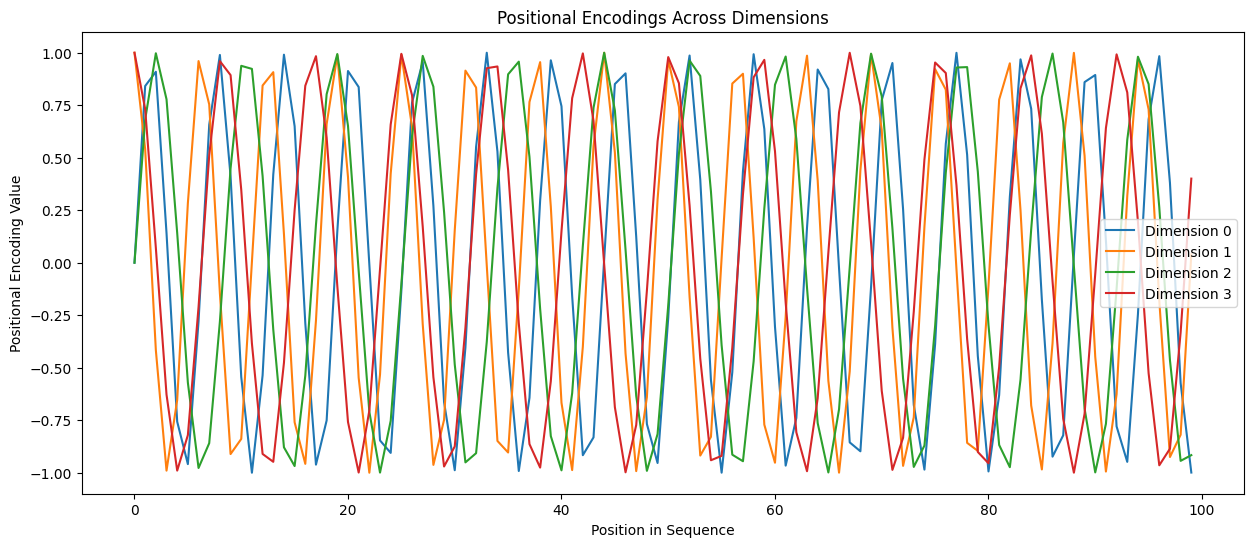

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_positional_encodings(embed_dim, max_len=100):
    # Compute positional encodings
    position = np.arange(max_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, embed_dim, 2) * (-np.log(10000.0) / embed_dim))
    pe = np.zeros((max_len, embed_dim))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)

    # Plot positional encodings for a few dimensions
    plt.figure(figsize=(15, 6))
    for i in range(4):  # Plot 4 different dimensions as examples
        plt.plot(pe[:, i], label=f"Dimension {i}")

    plt.xlabel("Position in Sequence")
    plt.ylabel("Positional Encoding Value")
    plt.title("Positional Encodings Across Dimensions")
    plt.legend()
    plt.show()

# Example plot
plot_positional_encodings(embed_dim=64, max_len=100)


### 4. Layer Normalization and Residual Connections in Transformers

Layer normalization and residual connections are two critical components in the Transformer architecture. They each play a unique role in stabilizing training, improving gradient flow, and helping the model learn more efficiently.

#### 1. **Layer Normalization**

Layer normalization is a technique that normalizes the inputs to each layer across the feature dimensions. It was introduced in Transformers to address the issue of internal covariate shift, where the distribution of inputs to a layer changes during training, potentially causing instability.

##### How Layer Normalization Works

For a given input $x$ with mean $\mu$ and standard deviation $\sigma$, layer normalization transforms it as follows:

$$
\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sigma} + \beta
$$

Where:
- $\mu$ and $\sigma$ are the mean and standard deviation computed across the feature dimensions.
- $\gamma$ and $\beta$ are learnable parameters that allow the normalized output to be scaled and shifted.

This normalization has the following benefits:
- **Stabilizes training**: By keeping the inputs to each layer in a consistent range, it reduces the risk of large variations in the gradients, which can destabilize training.
- **Improves gradient flow**: Normalized inputs help gradients propagate more easily through the network, preventing the model from getting "stuck" in certain parts.
- **Increases model efficiency**: Normalization makes each layer’s output more predictable, allowing the model to learn more effectively from the data.

In Transformers, layer normalization is applied after the self-attention and feedforward layers, ensuring consistent scaling for each layer's inputs.

##### Example Code for Layer Normalization in PyTorch

```python
import torch
import torch.nn as nn

# Example of layer normalization
layer_norm = nn.LayerNorm(normalized_shape=64)  # Assuming embedding dim is 64
x = torch.rand(2, 10, 64)  # Example tensor with batch size 2, sequence length 10, embedding dim 64

normalized_x = layer_norm(x)
print("Shape after LayerNorm:", normalized_x.shape)
```

#### 2. **Residual Connections**

Residual connections, also known as skip connections, are shortcuts that allow the input to "skip" certain layers. In a Transformer, residual connections are added after the attention and feedforward layers. They are essential for preserving information, improving gradient flow, and helping the model learn more stable representations.

##### Why Residual Connections Are Important

1. **Gradient Flow**: By allowing the input to bypass specific layers, residual connections help gradients propagate backward more easily, mitigating issues like vanishing or exploding gradients.
2. **Stability**: Residual connections allow the model to retain the original information, preventing drastic changes in the learned features.
3. **Learning Efficiency**: If a particular layer (e.g., attention or feedforward) doesn't provide much useful transformation, the model can effectively "skip" it by relying on the residual connection.

Mathematically, a residual connection in a Transformer can be represented as:

$$
\text{Output} = \text{Layer}(x) + x
$$

Where:
- $x$ is the input.
- $\text{Layer}(x)$ represents either the self-attention or feedforward output.

By adding the input $x$ back to the layer output, residual connections allow the network to dynamically decide how much of the transformed information to retain.

##### Combining Residual Connections and Layer Normalization

In a Transformer, the structure of each attention and feedforward layer with residual connections and layer normalization is:

1. **Self-Attention Block**:
   $$
   \text{AttentionOutput} = \text{LayerNorm}(\text{Attention}(x) + x)
   $$
2. **Feedforward Block**:
   $$
   \text{FeedForwardOutput} = \text{LayerNorm}(\text{FeedForward}(\text{AttentionOutput}) + \text{AttentionOutput})
   $$

This combination of residual connections and layer normalization helps the model maintain stable and efficient training dynamics.

#### Diagram Explanation

We can illustrate this process with a diagram:

```
Input (x)
    |
    |---------> Self-Attention
    |              |
    |              v
    |           Attention Output
    |              |
    |--------------+  <--- Residual Connection
    |              |
    |           LayerNorm
    |              |
    |---------> Feedforward Layer
    |              |
    |              v
    |           Feedforward Output
    |              |
    |--------------+  <--- Residual Connection
    |              |
    |           LayerNorm
    |
Final Output
```

In this flow:
- The **Self-Attention** layer receives the input $x$, computes the attention output, and then adds the input $x$ back through a residual connection.
- The result of this addition is normalized by **LayerNorm**.
- The normalized output then goes to the **Feedforward Layer**, which again adds a residual connection from its input, followed by another **LayerNorm**.

This layered structure with residual connections and layer normalization makes Transformers very stable and capable of training on large datasets with deep architectures.

### Additional Example

For a more interactive approach:
1. **Visualize the Gradients**: Show students the gradients with and without residual connections to demonstrate how they help maintain gradient flow.
2. **Experiment with Removing Residuals or Normalization**: Modify a simple Transformer implementation to show the impact of removing residual connections or layer normalization. This helps illustrate how these components are essential for effective learning.

By understanding layer normalization and residual connections, students can appreciate how Transformers handle deep architectures with stability and efficiency.

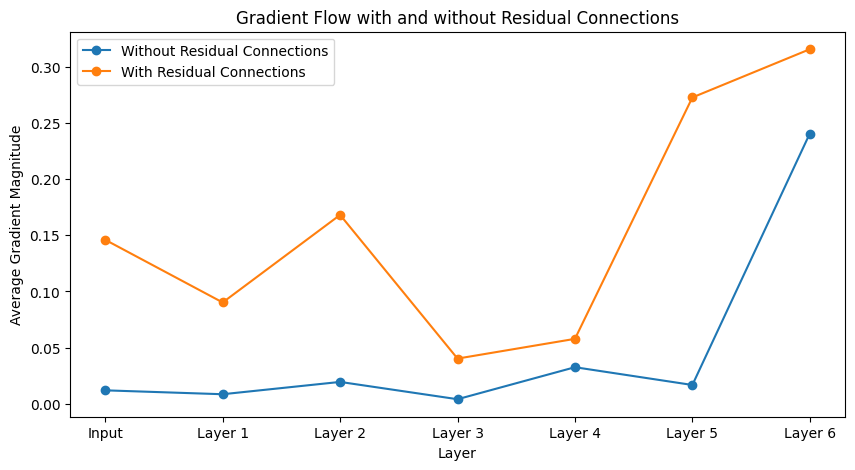

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a simple network without residual connections
class SimpleNetworkWithoutResidual(nn.Module):
    def __init__(self, layer_size=5):
        super(SimpleNetworkWithoutResidual, self).__init__()
        self.fc1 = nn.Linear(layer_size, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define a simple network with residual connections
class SimpleNetworkWithResidual(nn.Module):
    def __init__(self, layer_size=5):
        super(SimpleNetworkWithResidual, self).__init__()
        self.fc1 = nn.Linear(layer_size, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
    
    def forward(self, x):
        x1 = torch.relu(self.fc1(x)) + x  # Residual connection
        x2 = torch.relu(self.fc2(x1)) + x1  # Residual connection
        x3 = self.fc3(x2)
        return x3

# Function to calculate and store gradients for a given model
def compute_gradients(model, layer_size=5):
    # Random input and target
    x = torch.rand(1, layer_size, requires_grad=True)
    target = torch.rand(1, layer_size)
    
    # Reset gradients and forward pass
    model.zero_grad()
    output = model(x)
    loss = nn.MSELoss()(output, target)
    
    # Backward pass
    loss.backward()
    
    # Collect gradients
    gradients = [x.grad.abs().mean().item()]
    for param in model.parameters():
        gradients.append(param.grad.abs().mean().item())
    
    return gradients

# Visualize gradients for both models
def visualize_gradients():
    layer_size = 5
    model_without_residual = SimpleNetworkWithoutResidual(layer_size)
    model_with_residual = SimpleNetworkWithResidual(layer_size)

    # Compute gradients
    gradients_without_residual = compute_gradients(model_without_residual, layer_size)
    gradients_with_residual = compute_gradients(model_with_residual, layer_size)

    # Plot the gradients
    plt.figure(figsize=(10, 5))
    layers = ['Input'] + [f'Layer {i+1}' for i in range(len(gradients_without_residual) - 1)]
    
    plt.plot(layers, gradients_without_residual, label='Without Residual Connections', marker='o')
    plt.plot(layers, gradients_with_residual, label='With Residual Connections', marker='o')
    
    plt.xlabel("Layer")
    plt.ylabel("Average Gradient Magnitude")
    plt.title("Gradient Flow with and without Residual Connections")
    plt.legend()
    plt.show()

# Run the visualization
visualize_gradients()
